In [5]:
import folium
from folium.plugins import MarkerCluster, HeatMap
from matplotlib import cm
from matplotlib.colors import to_hex
from matplotlib.cm import plasma
import pandas as pd
from pathlib import Path
from IPython.display import display
import os
import dash
from dash import html, dcc, Input, Output
import dash_bootstrap_components as dbc
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns


# Configuração do diretório dos arquivos
diretorio_dados = Path("C:\\Users\\marlo\\OneDrive\\Documentos\\Data Driven PRF\\Tabelas_PRF")

# Configuração de colunas irrelevantes a serem removidas
colunas_remover = [
    'id_veiculo', 'marca', 'ano_fabricacao_veiculo', 'regional', 'delegacia', 'uop',
    'uso_solo', 'ilesos', 'feridos_leves', 'feridos_graves', 'mortos'
]

# Lista para armazenar DataFrames de todos os anos
dataframes = []

# Loop para carregar os dados de cada ano
for ano in range(2017, 2025):
    arquivo = diretorio_dados / f"acidentes{ano}_todas_causas_tipos.csv"
    if arquivo.exists():
        print(f"Carregando arquivo {arquivo}")
        # Carregando o arquivo
        df = pd.read_csv(arquivo, sep=';', encoding='latin1', dtype=str)
        
       
        # Filtrar apenas os dados de Petrópolis
        df = df[df['municipio'].str.upper() == "PETROPOLIS"]

        
        # Remover registros sem BR informada
        df = df[df['br'].notna()]
        
        # Converter 'data_inversa' para datetime
        df['data_inversa'] = pd.to_datetime(df['data_inversa'], dayfirst=True, errors='coerce')
        df = df.dropna(subset=['data_inversa'])
        
        # Converter 'horario' para datetime.time
        df['horario'] = pd.to_datetime(df['horario'], format='%H:%M:%S', errors='coerce').dt.time
        
        # Criar a coluna de data e hora
        df['data_hora'] = df.apply(
            lambda row: pd.Timestamp.combine(row['data_inversa'], row['horario']) if pd.notnull(row['horario']) else None,
            axis=1
        )
        df = df.dropna(subset=['data_hora'])
        
        # Converter e formatar 'km', 'latitude' e 'longitude'
        df['km'] = df['km'].str.replace('.', '', regex=False).str.replace(',', '.').astype(float, errors='ignore')
        df['latitude'] = df['latitude'].str.replace(',', '.', regex=False).astype(float, errors='ignore')
        df['longitude'] = df['longitude'].str.replace(',', '.', regex=False).astype(float, errors='ignore')
        
        # Filtrar apenas os registros de 'Condutor'
        df = df[df['tipo_envolvido'] == 'Condutor']
        
        # Remover colunas irrelevantes
        df = df.drop(columns=colunas_remover, errors='ignore')
        
        # Adicionar o DataFrame à lista
        dataframes.append(df)
    else:
        print(f"Arquivo {arquivo} não encontrado. Pulando...")

# Concatenar todos os DataFrames em um único
df_concatenado = pd.concat(dataframes, ignore_index=True)

# Criar o DataFrame dfpessoa (dados únicos por pessoa)
dfpessoa = df_concatenado.drop_duplicates(subset=['pesid']).sort_values(by='data_hora').reset_index(drop=True)

# Criar o DataFrame dfocorrencia (dados de todas as ocorrências)
dfocorrencia = df_concatenado.sort_values(by='data_hora').reset_index(drop=True)

# Salvar os DataFrames no diretório especificado
dfpessoa.to_csv(diretorio_dados / "dfpessoa_petro.csv", index=False, sep=';', encoding='latin1')
dfocorrencia.to_csv(diretorio_dados / "dfocorrencia_petro.csv", index=False, sep=';', encoding='latin1')

# Análise simples e resumo dos DataFrames
print(f"Resumo dos arquivos gerados:\n")
print(f"Arquivo 'dfpessoa_petro.csv': {dfpessoa.shape[0]} registros únicos de pessoas e {dfpessoa.shape[1]} colunas.")
print(f"Arquivo 'dfocorrencia_petro.csv': {dfocorrencia.shape[0]} registros de ocorrências e {dfocorrencia.shape[1]} colunas.\n")

# Exemplo de análise inicial
print("Classificação de acidentes mais frequentes em Petrópolis:")
print(dfpessoa['classificacao_acidente'].value_counts().head())


Carregando arquivo C:\Users\marlo\OneDrive\Documentos\Data Driven PRF\Tabelas_PRF\acidentes2017_todas_causas_tipos.csv
Carregando arquivo C:\Users\marlo\OneDrive\Documentos\Data Driven PRF\Tabelas_PRF\acidentes2018_todas_causas_tipos.csv
Carregando arquivo C:\Users\marlo\OneDrive\Documentos\Data Driven PRF\Tabelas_PRF\acidentes2019_todas_causas_tipos.csv
Carregando arquivo C:\Users\marlo\OneDrive\Documentos\Data Driven PRF\Tabelas_PRF\acidentes2020_todas_causas_tipos.csv
Carregando arquivo C:\Users\marlo\OneDrive\Documentos\Data Driven PRF\Tabelas_PRF\acidentes2021_todas_causas_tipos.csv
Carregando arquivo C:\Users\marlo\OneDrive\Documentos\Data Driven PRF\Tabelas_PRF\acidentes2022_todas_causas_tipos.csv
Carregando arquivo C:\Users\marlo\OneDrive\Documentos\Data Driven PRF\Tabelas_PRF\acidentes2023_todas_causas_tipos.csv
Carregando arquivo C:\Users\marlo\OneDrive\Documentos\Data Driven PRF\Tabelas_PRF\acidentes2024_todas_causas_tipos.csv
Resumo dos arquivos gerados:

Arquivo 'dfpessoa_

In [11]:
import folium
from folium.plugins import MarkerCluster
from matplotlib import cm
from matplotlib.colors import to_hex
import pandas as pd
from IPython.display import display

# Configuração de anos e cores
years = list(range(2017, 2025))
colors = [to_hex(cm.plasma(i / len(years))) for i in range(len(years))]

# Inicializa o mapa em Petrópolis
mapa = folium.Map(location=[-22.52, -43.19], zoom_start=12)

# Cria um cluster de marcadores
marker_cluster = MarkerCluster().add_to(mapa)

# Loop para adicionar marcadores para cada ano
for i, year in enumerate(years):
    # Filtra os dados para o ano específico
    df_year = dfpessoa[dfpessoa['data_inversa'].dt.year == year]
    
    # Filtra as localizações dos acidentes (latitude e longitude)
    localizacao_acidentes = df_year[['latitude', 'longitude']].dropna().values.tolist()
    
    # Adiciona um marcador para cada acidente no ano atual
    for loc in localizacao_acidentes:
        folium.Marker(
            location=loc,
            icon=folium.Icon(color="blue", icon_color=colors[i]),  
            popup=f"Ano: {year}"
        ).add_to(marker_cluster)

# Exibe o mapa no notebook
display(mapa)


In [13]:
import folium
from folium.plugins import HeatMap
from IPython.display import display

# Filtra as linhas onde 'estado_fisico' não é 'Não informado'
df_filtrado = dfpessoa[dfpessoa['estado_fisico'] != 'Não informado'].copy()

# Define uma escala de intensidade para o estado físico do condutor
estado_intensidade = {
    'Ileso': 1,           # Menor gravidade
    'Lesões Leves': 2,
    'Lesões Graves': 3,
    'Óbito': 4            # Maior gravidade
}

# Mapeia a intensidade no DataFrame
df_filtrado['intensidade'] = df_filtrado['estado_fisico'].map(estado_intensidade)

# Lista de locais de acidentes e intensidades para o mapa de calor
localizacao_acidentes = df_filtrado[['latitude', 'longitude', 'intensidade']].dropna().values.tolist()

# Centraliza o mapa em Petrópolis
mapa = folium.Map(location=[-22.52, -43.19], zoom_start=12)

# Adiciona o mapa de calor com intensidade variável
HeatMap(localizacao_acidentes, radius=15, blur=10, gradient={
    0.2: 'green',     # Ileso
    0.4: 'yellow',    # Lesões Leves
    0.6: 'orange',    # Lesões Graves
    1: 'red'          # Óbito
}).add_to(mapa)

# Exibe o mapa no notebook
display(mapa)


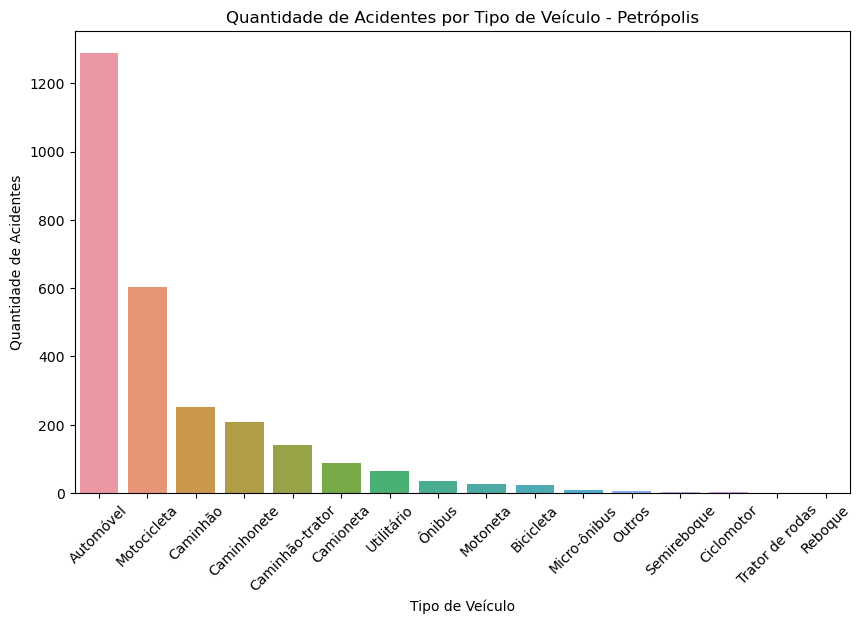

In [15]:
# Verifica se o DataFrame 'dfpessoa' existe e não está vazio
if dfpessoa is not None and not dfpessoa.empty:
    # Criação do gráfico
    plt.figure(figsize=(10, 6))
    sns.countplot(data=dfpessoa, x='tipo_veiculo', order=dfpessoa['tipo_veiculo'].value_counts().index)
    plt.xticks(rotation=45)
    plt.title('Quantidade de Acidentes por Tipo de Veículo - Petrópolis')
    plt.xlabel('Tipo de Veículo')
    plt.ylabel('Quantidade de Acidentes')
    plt.show()
else:
    print("DataFrame não encontrado ou está vazio para Petrópolis.")


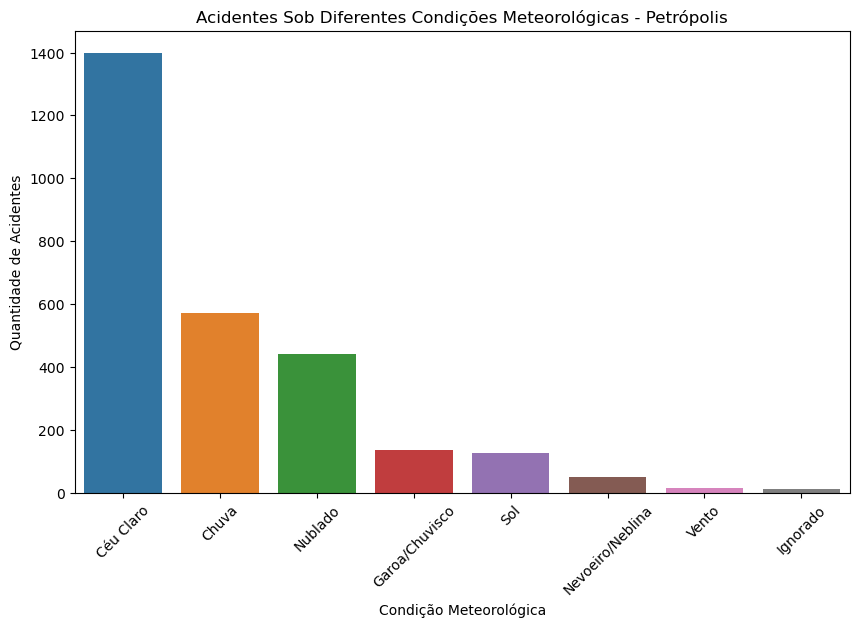

In [17]:
# Verifica se o DataFrame 'dfpessoa' está carregado e não está vazio
if dfpessoa is not None and not dfpessoa.empty:
    # Criação do gráfico
    plt.figure(figsize=(10, 6))
    sns.countplot(
        data=dfpessoa, 
        x='condicao_metereologica', 
        order=dfpessoa['condicao_metereologica'].value_counts().index
    )
    plt.xticks(rotation=45)
    plt.title('Acidentes Sob Diferentes Condições Meteorológicas - Petrópolis')
    plt.xlabel('Condição Meteorológica')
    plt.ylabel('Quantidade de Acidentes')
    plt.show()
else:
    print("DataFrame não encontrado ou está vazio para Petrópolis.")


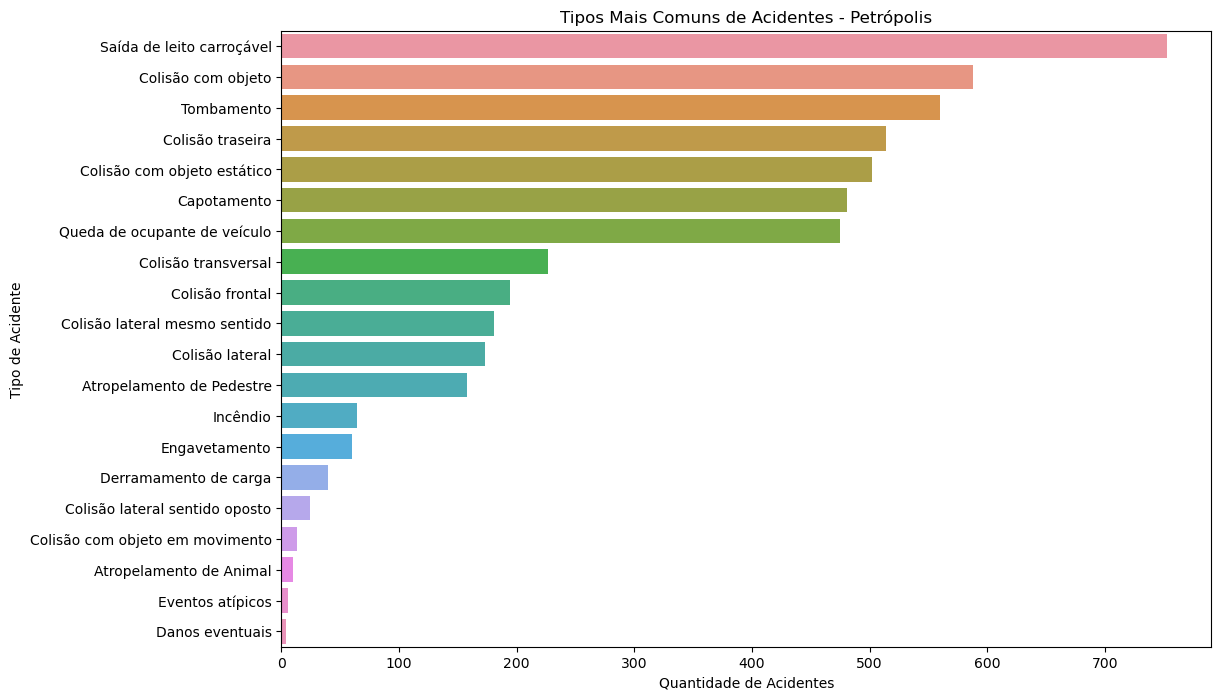

In [19]:
# Verifica se o DataFrame 'dfocorrencia' para Petrópolis está carregado e não está vazio
if dfocorrencia is not None and not dfocorrencia.empty:
    # Criação do gráfico para os tipos de acidentes
    plt.figure(figsize=(12, 8))
    sns.countplot(
        data=dfocorrencia, 
        y='tipo_acidente', 
        order=dfocorrencia['tipo_acidente'].value_counts().index
    )
    plt.title('Tipos Mais Comuns de Acidentes - Petrópolis')
    plt.xlabel('Quantidade de Acidentes')
    plt.ylabel('Tipo de Acidente')
    plt.show()
else:
    print("DataFrame não encontrado ou está vazio para Petrópolis.")


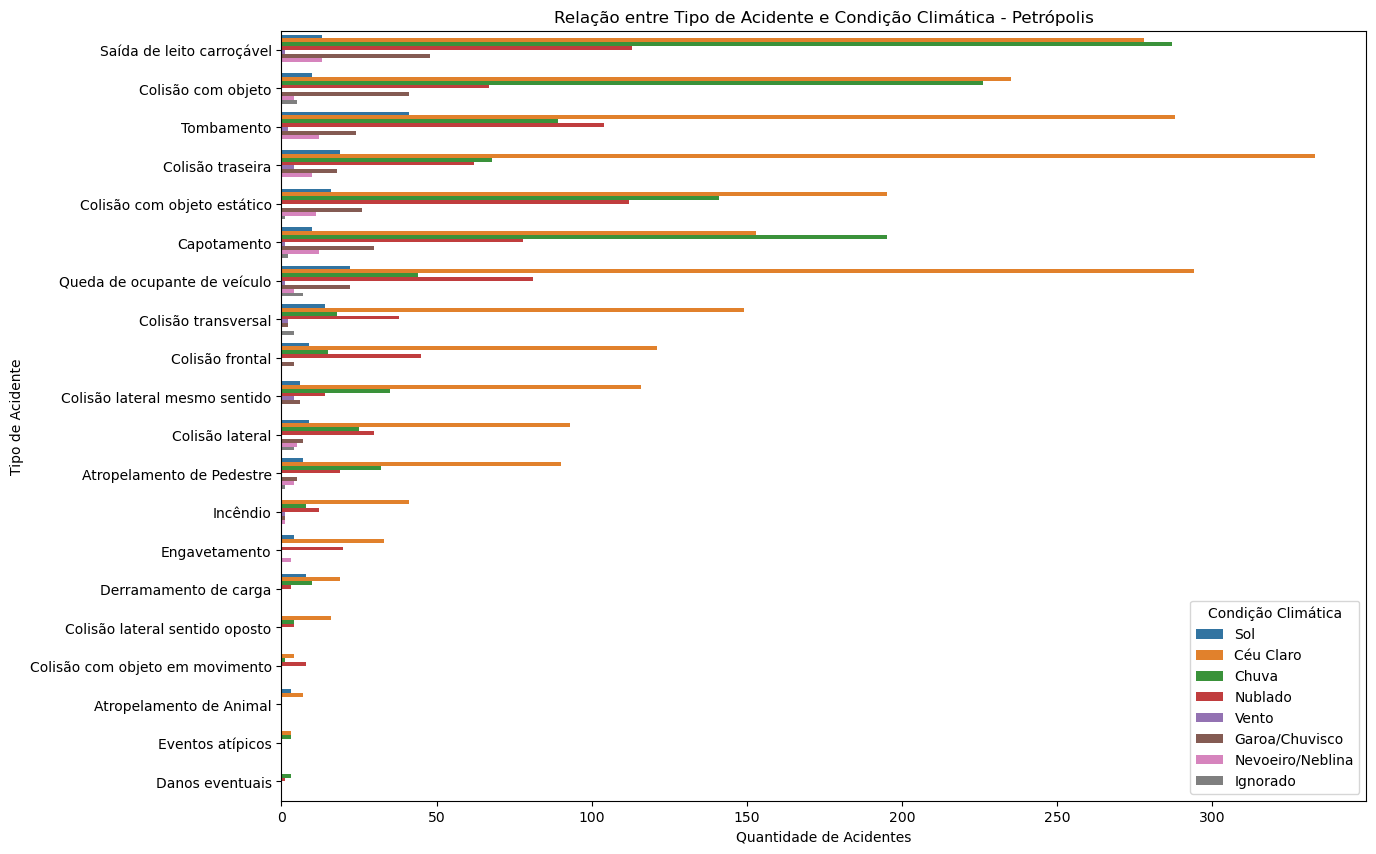

In [21]:
# Verifica se o DataFrame 'dfocorrencia' para Petrópolis está carregado e não está vazio
if dfocorrencia is not None and not dfocorrencia.empty:
    # Criação do gráfico para relação entre tipo de acidente e condição climática
    plt.figure(figsize=(14, 10))
    sns.countplot(
        data=dfocorrencia, 
        y='tipo_acidente', 
        hue='condicao_metereologica',  # Adiciona a condição meteorológica como agrupamento
        order=dfocorrencia['tipo_acidente'].value_counts().index
    )
    plt.title('Relação entre Tipo de Acidente e Condição Climática - Petrópolis')
    plt.xlabel('Quantidade de Acidentes')
    plt.ylabel('Tipo de Acidente')
    plt.legend(title='Condição Climática')
    plt.show()
else:
    print("DataFrame não encontrado ou está vazio para Petrópolis.")


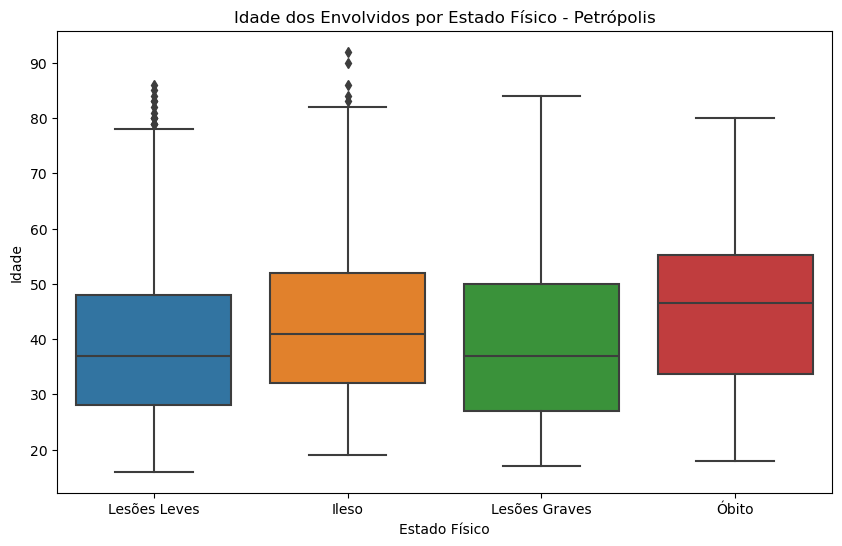

In [23]:
# Verifica se o DataFrame 'dfpessoa' para Petrópolis está carregado e não está vazio
if dfpessoa is not None and not dfpessoa.empty:
    # Trabalha com uma cópia para evitar modificar o DataFrame original
    df_trabalho_pessoa = dfpessoa.copy()

    # Garante que 'idade' seja numérica
    df_trabalho_pessoa['idade'] = pd.to_numeric(df_trabalho_pessoa['idade'], errors='coerce')
    df_trabalho_pessoa = df_trabalho_pessoa.dropna(subset=['idade'])  # Remove valores NaN em 'idade'

    # Verifica se há dados suficientes para plotar
    if not df_trabalho_pessoa.empty:
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=df_trabalho_pessoa, x='estado_fisico', y='idade')
        plt.title('Idade dos Envolvidos por Estado Físico - Petrópolis')
        plt.xlabel('Estado Físico')
        plt.ylabel('Idade')
        plt.show()
    else:
        print("Dados insuficientes para análise de idade e estado físico.")
else:
    print("DataFrame de pessoas não encontrado ou está vazio para Petrópolis.")


In [7]:



# Carregar os dados
def carregar_dataframe(tipo):
    caminho = diretorio_dados / f"df{tipo}_petro.csv"
    df = pd.read_csv(caminho, sep=";", encoding="latin1")
    
    # Verifique a existência de colunas e remova se necessário
    if 'data_inversa' in df.columns:
        df['data_inversa'] = pd.to_datetime(df['data_inversa'], errors='coerce')  # Certifique-se que a coluna é datetime
    df.set_index('data_inversa', inplace=True)  # Definir 'data_inversa' como índice

    # Retorne o DataFrame filtrado
    return df

# Carregar os dois tipos de dados
dfpessoa = carregar_dataframe("pessoa")
dfocorrencia = carregar_dataframe("ocorrencia")

# Configuração do aplicativo Dash
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

# Layout do aplicativo
app.layout = dbc.Container([
    dbc.Row([
        dbc.Col(html.H2("Análise de Acidentes em Petrópolis por Ano e Condição Climática"), className="text-center text-primary mb-4"),
    ]),
    dbc.Row([
        dbc.Col([
            dcc.Dropdown(
                id="anos-selecionados",
                options=[{"label": str(year), "value": year} for year in range(2017, 2025)],
                value=[2017],
                multi=True,
                clearable=False,
                placeholder="Selecione os Anos"
            ),
        ], width=4),
        dbc.Col([
            dcc.Dropdown(
                id="condicoes-climaticas",
                options=[{"label": cond, "value": cond} for cond in dfpessoa['condicao_metereologica'].unique()],
                multi=True,
                placeholder="Selecione Condições Climáticas",
                clearable=True
            ),
        ], width=4),
        dbc.Col([
            dcc.Dropdown(
                id="tipos-veiculo",
                options=[{"label": tipo, "value": tipo} for tipo in dfpessoa['tipo_veiculo'].unique()],
                multi=True,
                placeholder="Selecione o Tipo de Veículo",
                clearable=True
            ),
        ], width=4),
        dbc.Col([
            dcc.Dropdown(
                id="estados-fisicos",
                options=[{"label": estado, "value": estado} for estado in dfpessoa['estado_fisico'].unique()],
                multi=True,
                placeholder="Selecione o Estado Físico",
                clearable=True
            ),
        ], width=4),
        dbc.Col([
            dcc.RadioItems(
                id="tipo-mapa",
                options=[
                    {"label": "Mapa de Marcadores", "value": "marcador"},
                    {"label": "Mapa de Calor", "value": "calor"}
                ],
                value="marcador",
                labelStyle={'display': 'inline-block'}
            )
        ]),
        dbc.Col([
            dcc.RadioItems(
                id="tipo-dados",
                options=[
                    {"label": "Pessoa", "value": "pessoa"},
                    {"label": "Ocorrência", "value": "ocorrencia"}
                ],
                value="pessoa",
                labelStyle={'display': 'inline-block'}
            )
        ], width=4),
    ]),

    dbc.Row([
        dbc.Col([
            dcc.Graph(id="scatter-condicao-km-tipo")
        ], width=12)
    ]),

    dbc.Row([
        dbc.Col(html.Iframe(id="mapa-interativo", width="100%", height="600"))
    ])
])

# Callback para atualizar o DataFrame com base no tipo escolhido
@app.callback(
    Output('anos-selecionados', 'options'),
    Input('tipo-dados', 'value')
)
def atualizar_dados(tipo):
    global dfpessoa, dfocorrencia
    if tipo == 'pessoa':
        df = dfpessoa
    else:
        df = dfocorrencia
    return [{"label": str(year), "value": year} for year in range(2017, 2025)]

# Callback para atualizar gráfico de dispersão e mapa
@app.callback(
    [Output('scatter-condicao-km-tipo', 'figure'), Output('mapa-interativo', 'srcDoc')],
    [Input('anos-selecionados', 'value'), Input('condicoes-climaticas', 'value'),
     Input('tipos-veiculo', 'value'), Input('estados-fisicos', 'value'), Input('tipo-mapa', 'value'),
     Input('tipo-dados', 'value')]
)
def atualizar_analise(anos, condicoes, tipos_veiculo, estados_fisicos, tipo_mapa, tipo_dados):
    # Selecione o dataframe adequado
    if tipo_dados == 'pessoa':
        df_filtrado = dfpessoa
    else:
        df_filtrado = dfocorrencia
    
    # Filtra os dados pelo ano escolhido
    df_filtrado = df_filtrado[df_filtrado.index.year.isin(anos)]

    # Aplica os filtros adicionais
    if condicoes:
        df_filtrado = df_filtrado[df_filtrado['condicao_metereologica'].isin(condicoes)]
    if tipos_veiculo:
        df_filtrado = df_filtrado[df_filtrado['tipo_veiculo'].isin(tipos_veiculo)]
    if estados_fisicos:
        df_filtrado = df_filtrado[df_filtrado['estado_fisico'].isin(estados_fisicos)]

    # Criação do gráfico de dispersão
    fig = px.scatter(
        df_filtrado,
        x="km",
        y="tipo_veiculo",
        size=df_filtrado.groupby("km")["tipo_veiculo"].transform("count"),
        color="condicao_metereologica",
        title="Análise de Acidentes",
        labels={"km": "Quilômetro", "tipo_veiculo": "Tipo de Veículo", "condicao_metereologica": "Condição Climática"},
        hover_data={"latitude": True, "longitude": True}
    )

    # Criação do mapa de acordo com o tipo escolhido (Marcador ou Calor)
    mapa = folium.Map(location=[-22.52, -43.19], zoom_start=12)
    if tipo_mapa == "marcador":
        marker_cluster = MarkerCluster().add_to(mapa)
        for _, row in df_filtrado.iterrows():
            folium.Marker(
                location=[row["latitude"], row["longitude"]],
                popup=(f"KM: {row['km']}<br>Veículo: {row['tipo_veiculo']}<br>Condição: {row['condicao_metereologica']}<br>Estado Físico: {row['estado_fisico']}"),
                icon=folium.Icon(color="blue")
            ).add_to(marker_cluster)
    elif tipo_mapa == "calor":
        localizacao_acidentes = df_filtrado[['latitude', 'longitude', 'estado_fisico']].dropna()
        estado_intensidade = {'Ileso': 1, 'Lesões Leves': 2, 'Lesões Graves': 3, 'Óbito': 4}
        localizacao_acidentes['intensidade'] = localizacao_acidentes['estado_fisico'].map(estado_intensidade)
        HeatMap(
            data=localizacao_acidentes[['latitude', 'longitude', 'intensidade']].values.tolist(),
            radius=15, blur=10, gradient={0.2: 'green', 0.4: 'yellow', 0.6: 'orange', 1: 'red'}
        ).add_to(mapa)

    mapa.save("mapa_interativo.html")
    with open("mapa_interativo.html", "r", encoding="latin1") as f:
        mapa_html = f.read()

    return fig, mapa_html

if __name__ == "__main__":
    app.run_server(debug=True, port=8051)
